# Podstawy Przetwarzania Dużych Zbiorów Danych

Grupa IBD4 Poniedziałki 8:30

Łukasz Moskwa 247739

Artur Szewczykowski 252546


### 0.0 Importy i wczytanie do df


In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

df_data = pd.read_csv("../datasets/final_data.csv")
df_data['date'] = pd.to_datetime(df_data['date'])
df_data = df_data.sort_values('date')
df_europe = df_data[df_data['Continent'] == 'Europe'].copy()
df_europe

,Country_name,3_letter_code,population_urban,gdp_per_capita_usd,GDP_2022,date,Total_confirmed_cases,Total_new_deceased,Total_new_vaccinations,New_persons_fully_vaccinated,...,Murders_Rate_2012,Murders_Rate_2013,Murders_Rate_2014,Murders_Rate_2015,Murders_Rate_2016,Murders_Rate_2017,Murders_Rate_2018,Murders_Rate_2019,Murders_Rate_2020,Murders_Rate_2021
13038,Latvia,LVA,1304943.0,17818.0,3.420999e+10,2020-12-07,712,5,1.0,NaN,...,3.408588,2.461252,3.182435,3.363531,3.496369,4.143514,4.339671,3.391501,3.689936,3.041754
26746,Norway,NOR,4418218.0,75419.0,4.018484e+11,2020-12-08,392,2,5.0,NaN,...,0.537950,0.905393,0.564430,0.462396,0.515603,0.530565,0.470604,0.523533,0.576225,0.536737
26747,Norway,NOR,4418218.0,75419.0,4.018484e+11,2020-12-09,453,0,1.0,NaN,...,0.537950,0.905393,0.564430,0.462396,0.515603,0.530565,0.470604,0.523533,0.576225,0.536737
13039,Latvia,LVA,1304943.0,17818.0,3.420999e+10,2020-12-09,680,15,1.0,NaN,...,3.408588,2.461252,3.182435,3.363531,3.496369,4.143514,4.339671,3.391501,3.689936,3.041754
26748,Norway,NOR,4418218.0,75419.0,4.018484e+11,2020-12-10,435,21,1.0,NaN,...,0.537950,0.905393,0.564430,0.462396,0.515603,0.530565,0.470604,0.523533,0.576225,0.536737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,Italy,ITA,42651966.0,34456.0,2.079749e+12,2022-09-13,23161,93,306.0,216.0,...,0.880543,0.832330,0.787430,0.778644,0.672005,0.626625,0.599558,0.530740,0.478987,0.511476
23889,Austria,AUT,5194416.0,51448.0,4.557663e+11,2022-09-13,6177,1,98.0,0.0,...,0.960896,0.719379,0.491454,0.509117,0.618097,0.795681,0.972794,0.867123,0.729699,0.728530
16027,Czech Republic,CZE,7887156.0,23010.0,2.450519e+11,2022-09-13,3020,5,84.0,82.0,...,0.998947,0.855957,0.770168,0.836200,0.617425,0.626703,NaN,0.920577,0.731178,0.447161
9329,Italy,ITA,42651966.0,34456.0,2.079749e+12,2022-09-14,18854,69,239.0,222.0,...,0.880543,0.832330,0.787430,0.778644,0.672005,0.626625,0.599558,0.530740,0.478987,0.511476


### Część 1 - Analiza danych

### Część 2 - szeregi czasowe

Do analizy szeregów czasowych możemy stosować: średnie ruchome, dekompozycje oraz ARIMA (Autoregressive Integrated Moving Average), SARIMA (ARIMA ale z sezonowością). <br>
My zdecydowaliśmy się na analizę średnią ruchomą, ponieważ była ona bezpośrednio wspomniana w poleceniu zadania.

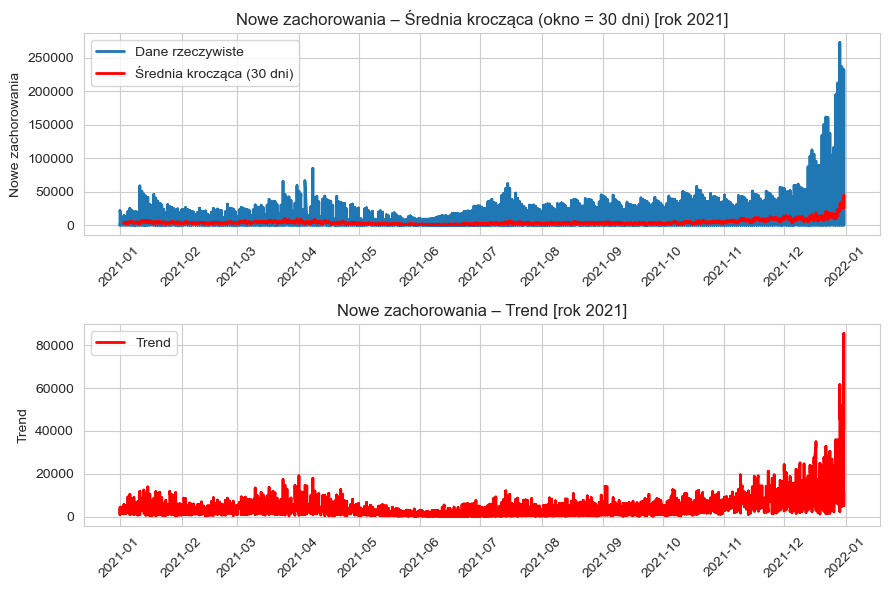

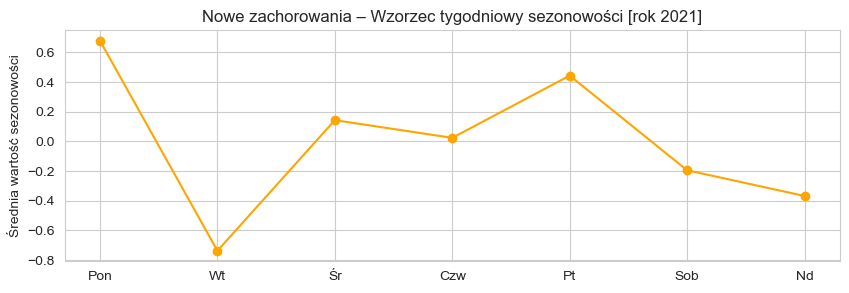

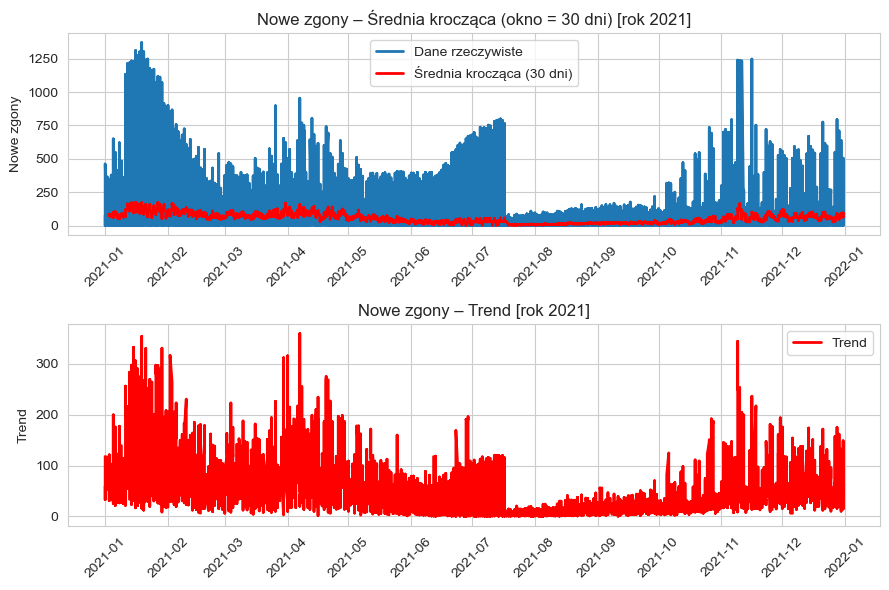

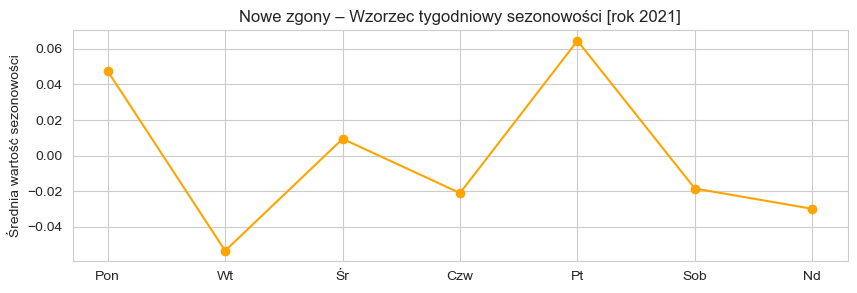

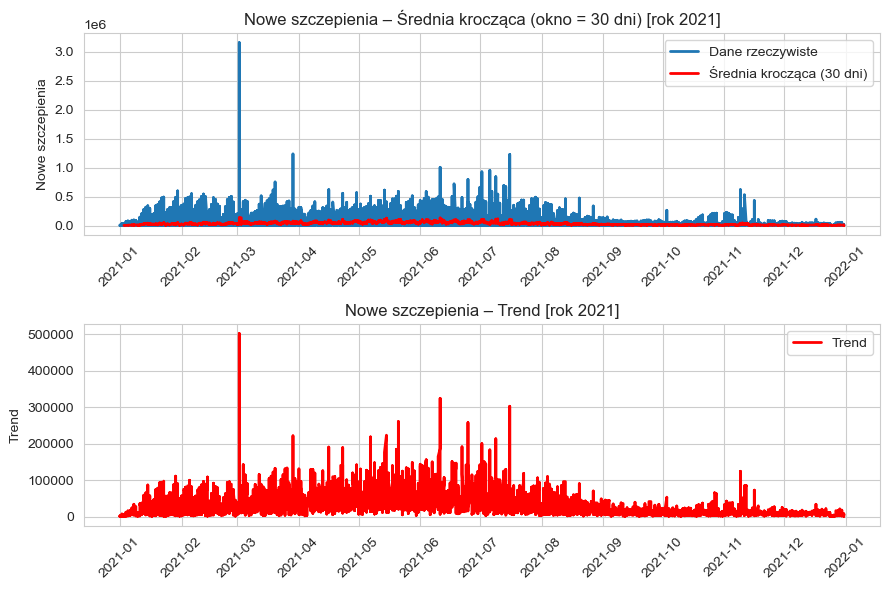

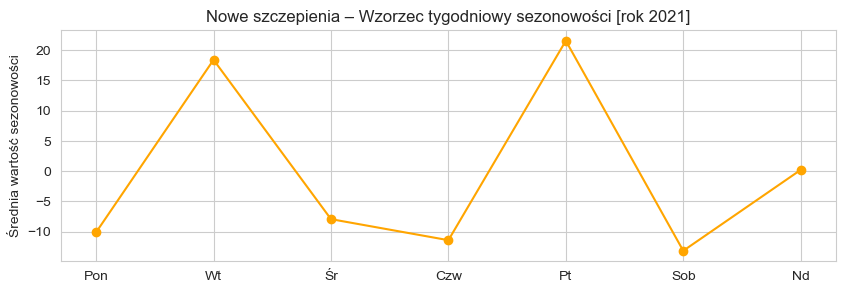

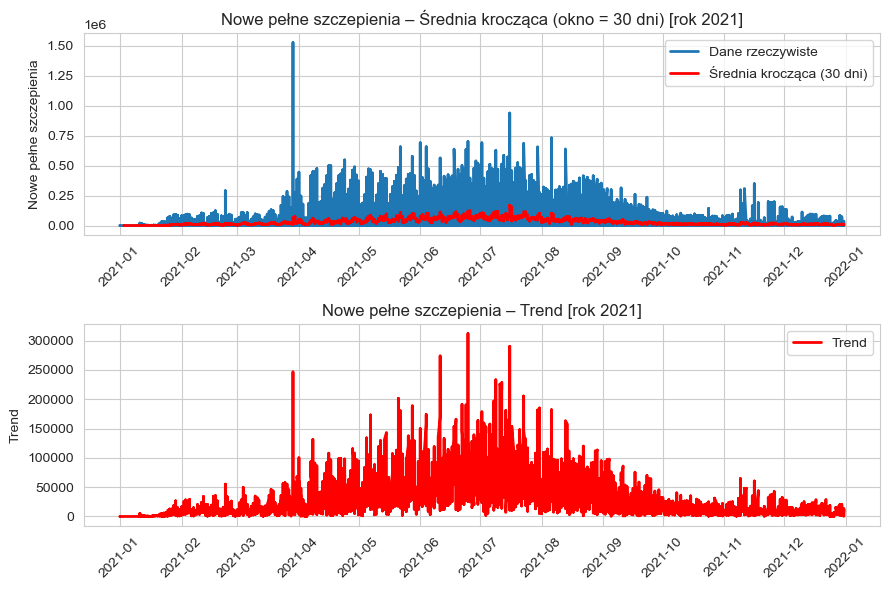

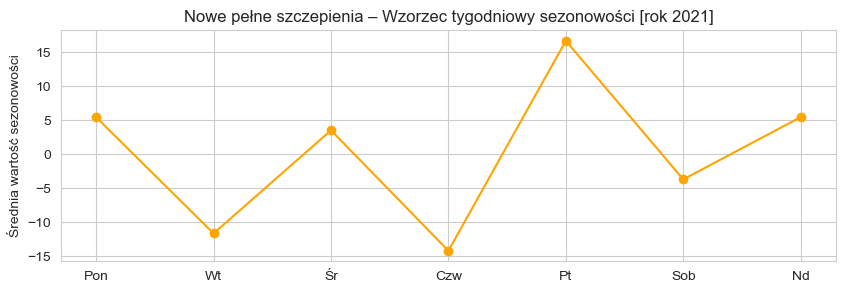

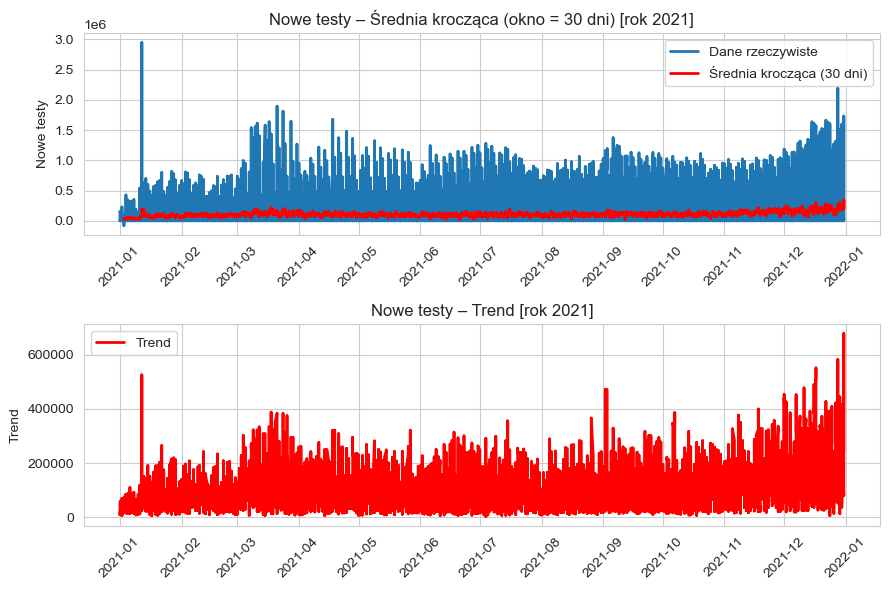

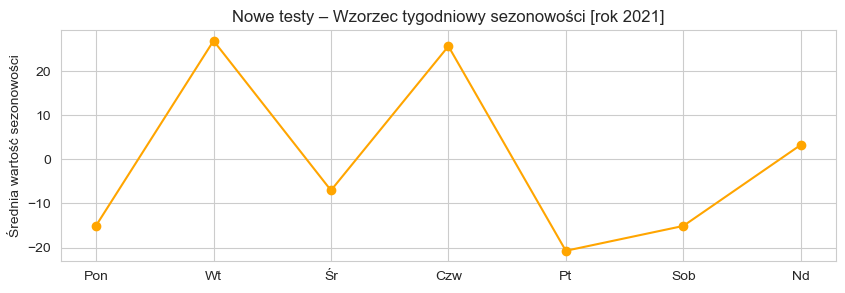

In [12]:
import statsmodels.api as sm
#----- to pomiędzy było w części 1 wiec jest do wywalenia
columns: dict = {
    'Nowe zachorowania': 'Total_confirmed_cases',
    'Nowe zgony': 'Total_new_deceased',
    'Nowe szczepienia': 'Total_new_vaccinations',
    'Nowe pełne szczepienia': 'New_persons_fully_vaccinated',
    'Nowe testy': 'Total_tested'
}

df_europe_ex1 = df_europe[['date', 'Country_name'] + list(columns.values())].copy()

for key, value in columns.items():
    df_europe_ex1[f'{key}_srednia_7dni'] = df_europe_ex1[value].rolling(window=7).mean()
    df_europe_ex1[f'{key}_odchylenie_7dni'] = df_europe_ex1[value].rolling(window=7).std()
#----- tu się kończy część do wywalenia
# --- Przygotowanie danych ---
df_europe_ex2 = df_europe_ex1.copy()
df_europe_ex2.set_index('date', inplace=True)
df_europe_ex2.index = pd.to_datetime(df_europe_ex2.index)
y_full = df_europe_ex2['Total_confirmed_cases'].dropna()

# Wybieramy dane tylko z roku 2021
y = y_full[(y_full.index >= '2021-01-01') & (y_full.index <= '2021-12-31')]

# --- Parametry ---
period = 7   # Okres sezonowości (np. tygodniowa sezonowość)
window = 30  # Okno dla średniej ruchomej (30 dni)

# --- Dekompozycja ---
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=period)

# --- Wykresy dla każdej zmiennej ---
for label, col in columns.items():
    y_full = df_europe_ex2[col].dropna()
    y = y_full[(y_full.index >= '2021-01-01') & (y_full.index <= '2021-12-31')]

    decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=period)

    fig, axes = plt.subplots(2, 1, figsize=(9, 6))

    # Wykres 1: Dane + średnia krocząca
    rolling_mean = y.rolling(window=window).mean()
    axes[0].plot(y.index, y.values, label='Dane rzeczywiste', linewidth=2)
    axes[0].plot(rolling_mean.index, rolling_mean.values, label=f'Średnia krocząca ({window} dni)', color='red', linewidth=2)
    axes[0].set_title(f'{label} – Średnia krocząca (okno = {window} dni) [rok 2021]')
    axes[0].set_ylabel(label)
    axes[0].legend()
    axes[0].grid(True)

    # Wykres 2: Trend
    axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color='red', linewidth=2)
    axes[1].set_title(f'{label} – Trend [rok 2021]')
    axes[1].set_ylabel('Trend')
    axes[1].legend()
    axes[1].grid(True)

    # Formatowanie dat
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Wzorzec tygodniowy sezonowości
    seasonality = decomposition.seasonal
    dow = seasonality.index.dayofweek
    weekly_pattern = seasonality.groupby(dow).mean()

    plt.figure(figsize=(10, 3))
    plt.plot(['Pon', 'Wt', 'Śr', 'Czw', 'Pt', 'Sob', 'Nd'], weekly_pattern.values,
             marker='o', linestyle='-', color='orange')
    plt.title(f'{label} – Wzorzec tygodniowy sezonowości [rok 2021]')
    plt.ylabel('Średnia wartość sezonowości')
    plt.grid(True)
    plt.show()

- Nowe zachorowania - znaczący wzrost zachorowań pod koniec roku, wcześniej stabilnie.
- Nowe zgony - trzy duże fale zgonów i znaczny spadek w okresie letnim.
- Nowe szczepienia - największa fala od kwienia do sierpnia, ale bez dużych, nagłych spadków/wzrostów.
- Nowe pełne szczepienia - podobne do szczepień, ale wzrosty były bardziej intensywne.
- Nowe testy - najmniejsze zróżnicowe, praktywnie brak nagłych fal bądź spadków.

### Część 3 - analiza regresji

### Część 4 - regresja wielomianowa

In [13]:
#dostawić do importów z wcześniejszych części
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

Przygotowanie danych - filtracja i zamiast formatu date liczymy datę jako liczba dni od pierwszego dnia z naszego zbioru.

In [14]:
df_Norway = df_europe[df_europe[('Country_name')] == 'Norway'].copy()
df_Norway['days'] = (df_Norway['date'] - df_Norway['date'].min()).dt.days
kolumny = {
    'Nowe zachorowania': 'Total_confirmed_cases',
    'Nowe zgony': 'Total_new_deceased',
    'Nowe szczepienia': 'Total_new_vaccinations',
    'Nowe pełne szczepienia': 'New_persons_fully_vaccinated',
    'Nowe testy': 'Total_tested'
}

<b>Badanie</b>

Do porównywania stopniu wielomianów oraz regresji liniowej korzystamy z:
 - współczynnika determinacji R^2, który  jaka część całkowitej zmienności wartości rzeczywistych jest wyjaśniona przez model <br>
(1 = idealne dopasowanie, 0 = model nic nie wyjaśnia, -1 = model jest gorszy niż losowanie).

- MSE - błąd średniokwadratowy - średnia z kwadratów różnic między wartościami rzeczywistymi a przewidywanymi przez model.

In [15]:
def analyze_polynomial_regression(df, feature_col, name, max_degree=15):
    X = df[['days']].values
    y = df[feature_col].fillna(0).values

    results = []

    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)

        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        results.append((degree, r2, mse, y_pred))

    best = max(results, key=lambda x: x[1])  # najlepsze R²
    best_degree, best_r2, best_mse, best_pred = best

    # model liniowy dla porównania
    model_lin = LinearRegression()
    model_lin.fit(X, y)
    y_lin_pred = model_lin.predict(X)
    lin_r2 = r2_score(y, y_lin_pred)
    lin_mse = mean_squared_error(y, y_lin_pred)


    # wykres
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], y, label='Rzeczywiste dane', color='black')
    plt.plot(df['date'], best_pred, label=f'Regresja wielomianowa (stopień {best_degree})', color='blue')
    plt.plot(df['date'], y_lin_pred, label='Regresja liniowa', color='red')
    plt.title(f'{name} - analiza regresji')
    plt.xlabel('Data')
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{name} — najbardziej dopasowany jest wielomian stopnia {best_degree}")
    print("\nModel wielomianowy vs liniowy:\n")
    print(f" R² dla modelu liniowego: {lin_r2:.2f}")
    print(f" R² dla modelu wielomianowego: {best_r2:.2f}\n")
    print(f" MSE modelu wielomianowego: {best_mse:.2f}")
    print(f" MSE modelu liniowego: {lin_mse:.2f}\n")

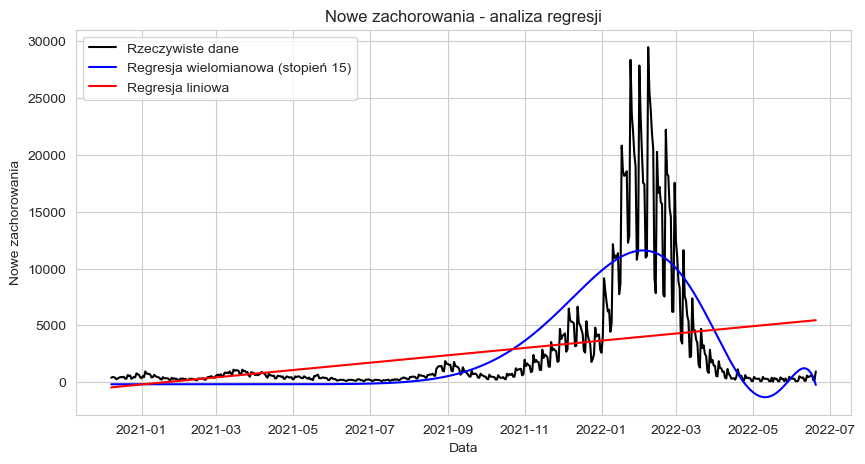

Nowe zachorowania — najbardziej dopasowany jest wielomian stopnia 15

Model wielomianowy vs liniowy:

 R² dla modelu liniowego: 0.12
 R² dla modelu wielomianowego: 0.64

 MSE modelu wielomianowego: 8800125.15
 MSE modelu liniowego: 21740357.76



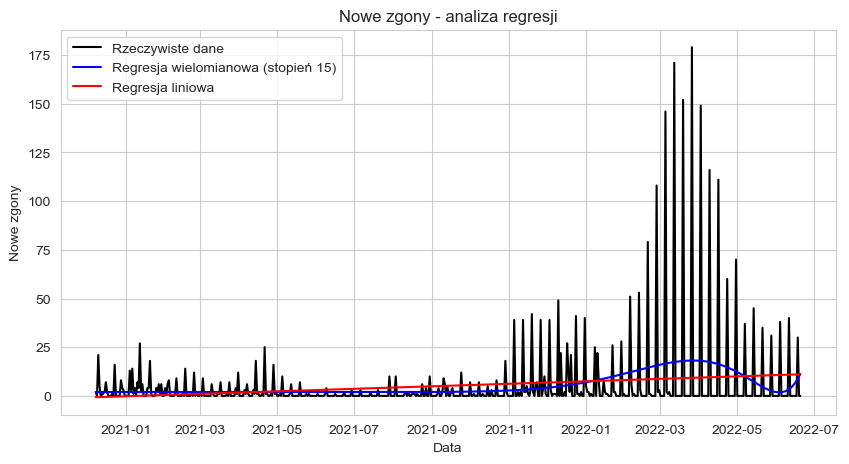

Nowe zgony — najbardziej dopasowany jest wielomian stopnia 15

Model wielomianowy vs liniowy:

 R² dla modelu liniowego: 0.03
 R² dla modelu wielomianowego: 0.07

 MSE modelu wielomianowego: 340.30
 MSE modelu liniowego: 355.53



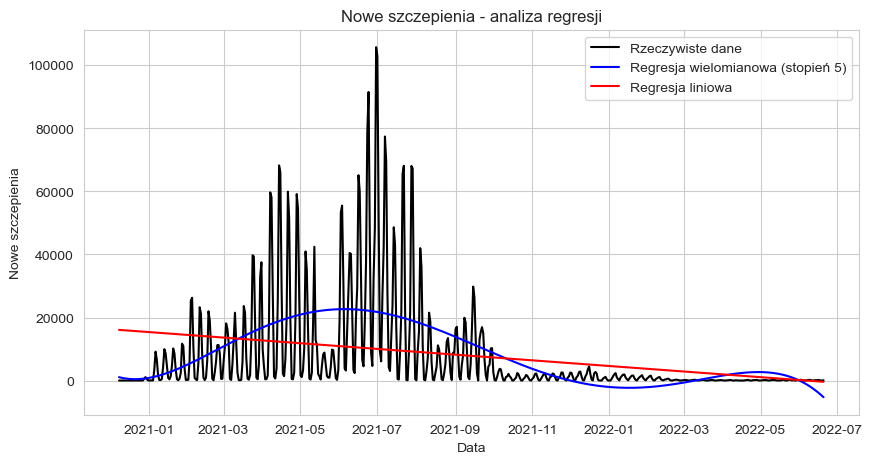

Nowe szczepienia — najbardziej dopasowany jest wielomian stopnia 5

Model wielomianowy vs liniowy:

 R² dla modelu liniowego: 0.09
 R² dla modelu wielomianowego: 0.31

 MSE modelu wielomianowego: 171319327.99
 MSE modelu liniowego: 225321100.51



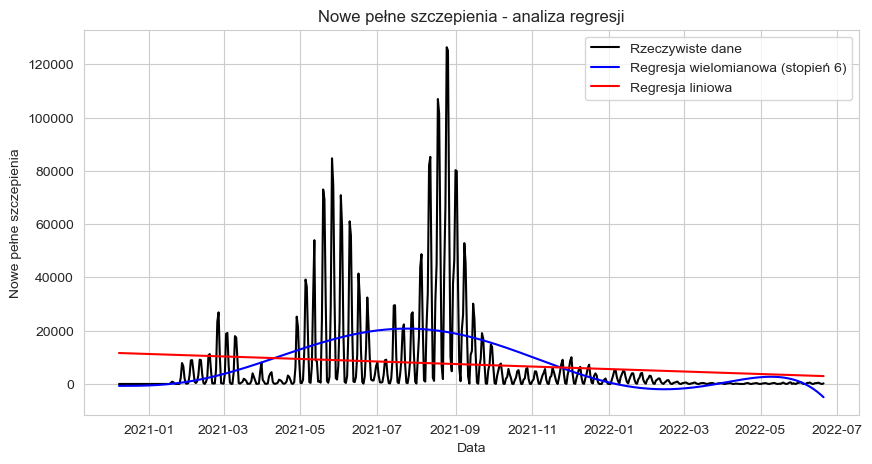

Nowe pełne szczepienia — najbardziej dopasowany jest wielomian stopnia 6

Model wielomianowy vs liniowy:

 R² dla modelu liniowego: 0.02
 R² dla modelu wielomianowego: 0.23

 MSE modelu wielomianowego: 218315472.62
 MSE modelu liniowego: 275786670.59



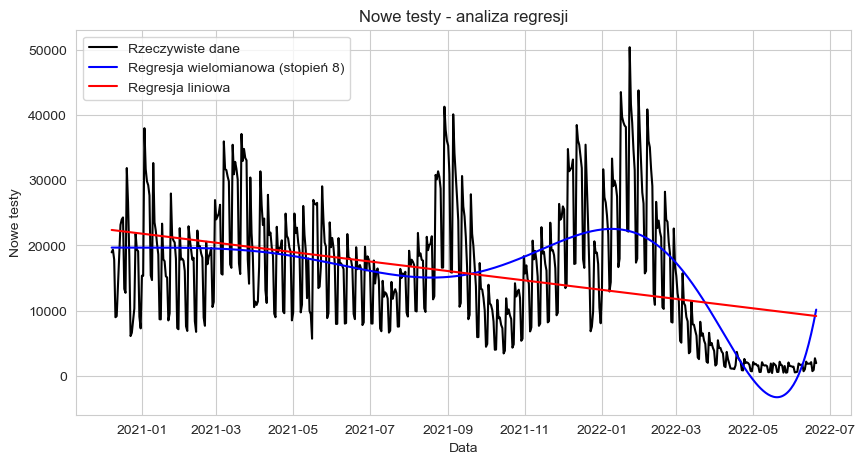

Nowe testy — najbardziej dopasowany jest wielomian stopnia 8

Model wielomianowy vs liniowy:

 R² dla modelu liniowego: 0.14
 R² dla modelu wielomianowego: 0.42

 MSE modelu wielomianowego: 60720899.44
 MSE modelu liniowego: 89434733.57



In [16]:
for name, feature_col in kolumny.items():
    analyze_polynomial_regression(df_Norway, feature_col, name)

- R² w każdym przypadku jest większe dla modelu wielomianowego niż liniowego.
- MSE w każdym przypadku jest większe dla modelu liniowego niż wielomianowego.
- Oznacza to, że w każdym przypadku regresja wielomianowa jest lepszym rozwiązaniem.
- Najlepiej dopasowane do regresji wielomianowej są nowe zachorowania (R²=0,64), nowe testy mają także niezły wynik (R²=0,42).
- Szczepienia i pełne szczepienia są gorzej dopasowane, ale mimo wszystko regresja wielomianowa pokazuje główny trend (R²=0,31 i R²=0,23).
- Nowe śmierci mają znikome dopasowanie nawet dla regresji wielomianowej (R²=0,07), ale nawet w takim słabym przypadku poradziła ona sobie lepiej od regresji liniowej.

### Część 5 - regresja liniowa 2 państw